# Pitch F/X 데이터를 활용한 분석
Pitch F/X 데이터는 `pfx.py`를 사용해 N사의 문자중계(gameday) 시스템에서 읽어올 수 있으며, `pbp_data`경로 아래에 연도/월별로 CSV 포맷으로 저장된다.

여기서는 `pfx.py`로 다운받은 데이터를 `pandas` 모듈을 사용하여 시각화하고 분석하는 예제를 제공한다.

`pandas`의 자세한 사용 방법을 기술하기에는 시간이 오래 걸리므로 생략한다.

분석에 필요한 함수는 `pfx_plot.py` 안에 미리 준비되어 있다.

## 1. 준비
필요한 모듈을 로드한다.

In [1]:
%matplotlib inline

# pandas 모듈은 흔히 pd라는 약칭으로 사용된다. Global 표준에 가깝다.
import pandas as pd
from IPython.display import HTML
from IPython.display import display

# 커스텀 라이브러리를 import한다.
from pfx_plot import *

# precision 세팅을 한다. 내부 값은 소수점 1자리까지만 표시되도록 저장하고, display 시에도 마찬가지로 표시하도록 한다.
pd.set_option('precision', 1)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

## 2. 데이터 읽어오기
PFX parser를 이용해 데이터는 CSV 포맷으로 저장되어 있다고 가정한다.

그렇지 않고 Linux/Mac을 사용하는 경우, 크롤러가 저장된 경로에서 아래 cell을 실행하면 2018년 3월 데이터를 새로 다운로드받고 파싱해서 저장한다.
- windows에서는 /dev/null이 없으므로 오류가 생길 수 있다.
 - 다만 cygwin Terminal이나 Git Bash shell 등에서 Jupyter Notebook을 실행 중이라면 괜찮을 것이다(/dev/null이 있을 것이므로).
- 현재 이 코드를 작성하는 시점이 2018년 3월이라서 3월 것을 다운로드받도록 했다.

In [3]:
!python pfx.py -d 2018 3 > /dev/null
!python pfx.py -c 2018 3 > /dev/null

2018년도 play-by-play 데이터를 pandas DataFrame으로 로드한다.

In [7]:
df = pd.read_csv('pbp_data/2018/2018.csv')
# Windows(한글)에서 저장한 데이터를 로드할 때는 아래 코드를 실행한다.
# df = pd.reac_csv('pbp_data/2018/2018.csv', encoding='cp949')

# show some
display(df[:5])

,pitch_type,pitcher,batter,pitcher_ID,batter_ID,speed,pitch_result,pa_result,balls,strikes,...,pos_7,pos_8,pos_9,game_date,home,away,stadium,referee,pa_number,pitch_number
0,직구,로저스,이용규,65742,74163,147,헛스윙,None,0,0,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,1,1
1,직구,로저스,이용규,65742,74163,147,스트라이크,None,0,1,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,1,2
2,슬라이더,로저스,이용규,65742,74163,135,스트라이크,삼진,0,2,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,1,3
3,직구,로저스,양성우,65742,62797,147,볼,None,0,0,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,2,1
4,직구,로저스,양성우,65742,62797,146,볼,None,1,0,...,이정후,임병욱,초이스,20180324,WO,HH,고척,최수원,2,2


로드된 데이터를 보면 열(column)이 길어서 중간에 축약 처리(`...`)가 된 것을 볼 수 있다.

열의 이름을 알기 위해 CSV 파일을 엑셀이나 텍스트 에디터로 열어보는 방법도 있지만, 1MB 이상 되는 파일을 매번 열어보는 건 시간상 현명한 선택이 아니다.

대신 pandas DataFrame에 내장된 기능을 사용, 로드한 데이터의 key를 알아낼 수 있다.

In [8]:
display(df.keys())

Index(['pitch_type', 'pitcher', 'batter', 'pitcher_ID', 'batter_ID', 'speed',
       'pitch_result', 'pa_result', 'balls', 'strikes', 'outs', 'inning',
       'inning_topbot', 'score_away', 'score_home', 'stands', 'throws',
       'on_1b', 'on_2b', 'on_3b', 'px', 'pz', 'pfx_x', 'pfx_z', 'x0', 'z0',
       'sz_top', 'sz_bot', 'pos_1', 'pos_2', 'pos_3', 'pos_4', 'pos_5',
       'pos_6', 'pos_7', 'pos_8', 'pos_9', 'game_date', 'home', 'away',
       'stadium', 'referee', 'pa_number', 'pitch_number'],
      dtype='object')

'key'는 CSV 파일의 열 이름을 뜻한다. 40여개 가까운 key가 있다. 매번 외울 수는 없으니 기억이 나지 않을 때마다 `df.keys()`를 잘 활용해주자.

## 3. 데이터 전처리

본격적인 분석을 하기에 앞서, 한가지 더 해야 할 것이 있다. 쓰레기값(Null)을 갖는 데이터 행(row)을 삭제하는 것이다.

예를 들어서 엑셀에서 CSV파일을 연 경우, 구속의 평균을 내야 하는데 숫자가 아닌 `NaN`(Not a Number; 숫자가 아님)이나 'None' 같은 문자 데이터가 들어있다면 Average 함수가 정상 작동하지 않을 것이다.

pandas도 마찬가지다. 웬만한 건 스마트하게 처리해주지만, 저런 필요 없는/에러를 유발할 수 있는 데이터는 삭제해줘야 한다.

In [12]:
# 쓰레기 값이 있는 데이터의 예시
display(df.loc[df.pitch_type.isnull()].loc[:, ['pitch_type', 'pitcher', 'batter', 'speed', 'px', 'pz']][:3])
display(df.loc[df.pitch_type == 'None'].loc[:, ['pitch_type', 'pitcher', 'batter', 'speed', 'px', 'pz']][:3])

,pitch_type,pitcher,batter,speed,px,pz
1432,NaN,윤성환,파레디스,0,-1.72259,2.83779
1433,NaN,윤성환,파레디스,0,0.28726,2.44873
2348,NaN,윤성빈,한동민,0,0.87464,1.6864


,pitch_type,pitcher,batter,speed,px,pz
514,None,헥터,로하스,None,None,None
674,None,왕웨이중,가르시아,None,None,None
675,None,왕웨이중,김현수,None,None,None


위 예시에서 보면 `pitch_type` 열에 `NaN`이나 'None' 같은 값이 있다. 철저히 배제해야 한다.

방법은 다음과 같다.

In [15]:
# NaN 처리; 숫자로 된 key는 대부분 쓰레기값이 섞여있다.
df.loc[:, 'speed'] = pd.to_numeric(df.speed, errors='coerce')
df.loc[:, 'px'] = pd.to_numeric(df.px, errors='coerce')
df.loc[:, 'pz'] = pd.to_numeric(df.pz, errors='coerce')
df.loc[:, 'pfx_x'] = pd.to_numeric(df.pfx_x, errors='coerce')
df.loc[:, 'pfx_z'] = pd.to_numeric(df.pfx_z, errors='coerce')
df.loc[:, 'x0'] = pd.to_numeric(df.x0, errors='coerce')
df.loc[:, 'z0'] = pd.to_numeric(df.z0, errors='coerce')

# pitch_type이 'NaN'인 row는 drop한다.
df = df.drop(df.loc[df.pitch_type.isnull()].index)

# pitch_type이 'None'인 row는 drop한다.
df = df.drop(df.loc[df.pitch_type == 'None'].index)

이렇게 제거했는데도 쓰레기 값이 섞여있을 수 있다. 확인해보자.

In [19]:
display(df.isnull().any().any())
print()
display(df.isnull().any())

True

pitch_type       False
pitcher          False
batter           False
pitcher_ID       False
batter_ID        False
speed            False
pitch_result     False
pa_result        False
balls            False
strikes          False
outs             False
inning           False
inning_topbot    False
score_away       False
score_home       False
stands           False
throws           False
on_1b            False
on_2b            False
on_3b            False
px               False
pz               False
pfx_x            False
pfx_z            False
x0               False
z0               False
sz_top           False
sz_bot           False
pos_1            False
pos_2            False
pos_3            False
pos_4            False
pos_5            False
pos_6            False
pos_7            False
pos_8            False
pos_9            False
game_date        False
home             False
away             False
stadium          False
referee           True
pa_number        False
pitch_numbe

실행 결과 referee 열에 쓰레기값이 섞여있는 게 확인된다. referee 데이터가 분석에 필요하다면 제거해주는 것이 좋다.

물론 데이터가 잘못 다운로드됐거나, 파싱이 잘못됐을 가능성도 있다.

여기서는 referee 관련 분석을 진행하지 않을 것이므로, 일단 넘어가도록 한다.

# 투수 데이터 분석

PBP 데이터에는 Pitch F/X 데이터가 들어있다. Pitch F/X 데이터는 투수 구속, 구종 이름, 무브먼트, 로케이션, 릴리즈 포인트 등을 포함한다.

이 데이터를 활용하는 예 중 하나는 '투수 레퍼토리 분석'이다. 예시로 켈리의 구종별 구속, break(무브먼트) 등을 알아보자.

In [24]:
# pitcher 이름이 '켈리'인 데이터만 읽어온다.
sub_df = df.loc[df.pitcher == '켈리']

print('켈리 데이터 개수 : {}개'.format(len(sub_df)))
display(sub_df[:3])

켈리 데이터 개수 : 102개


,pitch_type,pitcher,batter,pitcher_ID,batter_ID,speed,pitch_result,pa_result,balls,strikes,...,pos_7,pos_8,pos_9,game_date,home,away,stadium,referee,pa_number,pitch_number
894,직구,켈리,민병헌,65856,76249,148.0,스트라이크,None,0,0,...,정의윤,정진기,한동민,20180324,SK,LT,문학,박기택,1,1
895,직구,켈리,민병헌,65856,76249,147.0,볼,None,0,1,...,정의윤,정진기,한동민,20180324,SK,LT,문학,박기택,1,2
896,직구,켈리,민병헌,65856,76249,148.0,볼,None,1,1,...,정의윤,정진기,한동민,20180324,SK,LT,문학,박기택,1,3


데이터를 읽어왔지만 102구나 되는 내용을 일일이 들여다보기에는 시간이 부족하다.

구종 별로 묶어서 평균 구속, 최고 구속 등을 볼 수 있다면 시간이 절약될 것이다.

이럴 때 활용할 수 있는 게 `pandas DataFrame`의 `groupby` 함수다.

In [22]:
# pitch_type으로 묶어서 각 열 데이터의 평균(mean)을 구하고, 그 중 speed, pfx_x, pfx_z만 가져온다.
groupped = sub_df.groupby('pitch_type').mean().loc[:, ('speed', 'pfx_x', 'pfx_z')]

# 구종별 개수가 없으니 추가한다. count()는 모든 열에 동일한 값(해당 group의 개수)이 들어가므로, 그 중 한 열만 긁어오는 것이 핵심이다. speed가 아니어도 된다.
groupped['count'] = sub_df.groupby('pitch_type').count().speed

# 비슷하게 speed의 max, min 값도 추가한다.
groupped['max'] = sub_df.groupby('pitch_type').max().speed
groupped['min'] = sub_df.groupby('pitch_type').min().speed

# 확인해본다.
display(groupped)

,speed,pfx_x,pfx_z,count,max,min
pitch_type,,,,,,
슬라이더,135.0,2.8,2.5,7,136.0,133.0
직구,147.1,-5.5,9.4,32,150.0,144.0
체인지업,135.9,-8.4,7.2,16,140.0,131.0
커브,130.4,3.9,-2.8,23,136.0,125.0
커터,142.4,-5.0,7.9,12,146.0,138.0
투심,145.1,-7.7,8.7,12,149.0,137.0


원하던대로 구종별 구속, 브레이크 값 등을 정리했다. 포심(직구) 평균구속 147, 최고구속 150인 것을 보면 알려진 켈리의 데이터와 유사하다.

또한 앞서 pitch_type 열에서 `NaN`, 'None' 같은 값을 제거했기 때문에 이상한 그룹이 나오지 않는다.

제거하지 않았다면 슬라이더 위에 'None' 그룹이 표시되거나, 평균 계산이 제대로 되지 않았을 것이다.

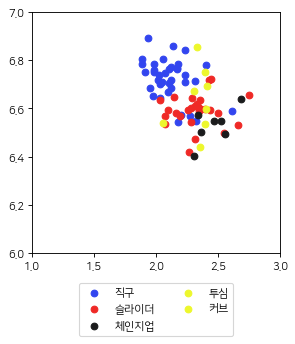

In [54]:


Colors = {
    '직구': '#3245ef',
    '슬라이더': '#ef2926',
    '체인지업':'#1a1b1c',
    '커브':'#edf72c',
    '포크':'#8348d1',
    '투심':'#edf72c',
    '커터':'#1a1b1c'
}

pt = sub_df.pitch_type.drop_duplicates()

fig = plt.figure(figsize=(4, 4), dpi=80, facecolor='white')
for p in pt:
    plt.scatter(sub_df.loc[sub_df.pitch_type == p].x0, sub_df.loc[sub_df.pitch_type == p].z0, color=Colors[p], label=p)
    
plt.axis([1, 3, 6, 7])
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

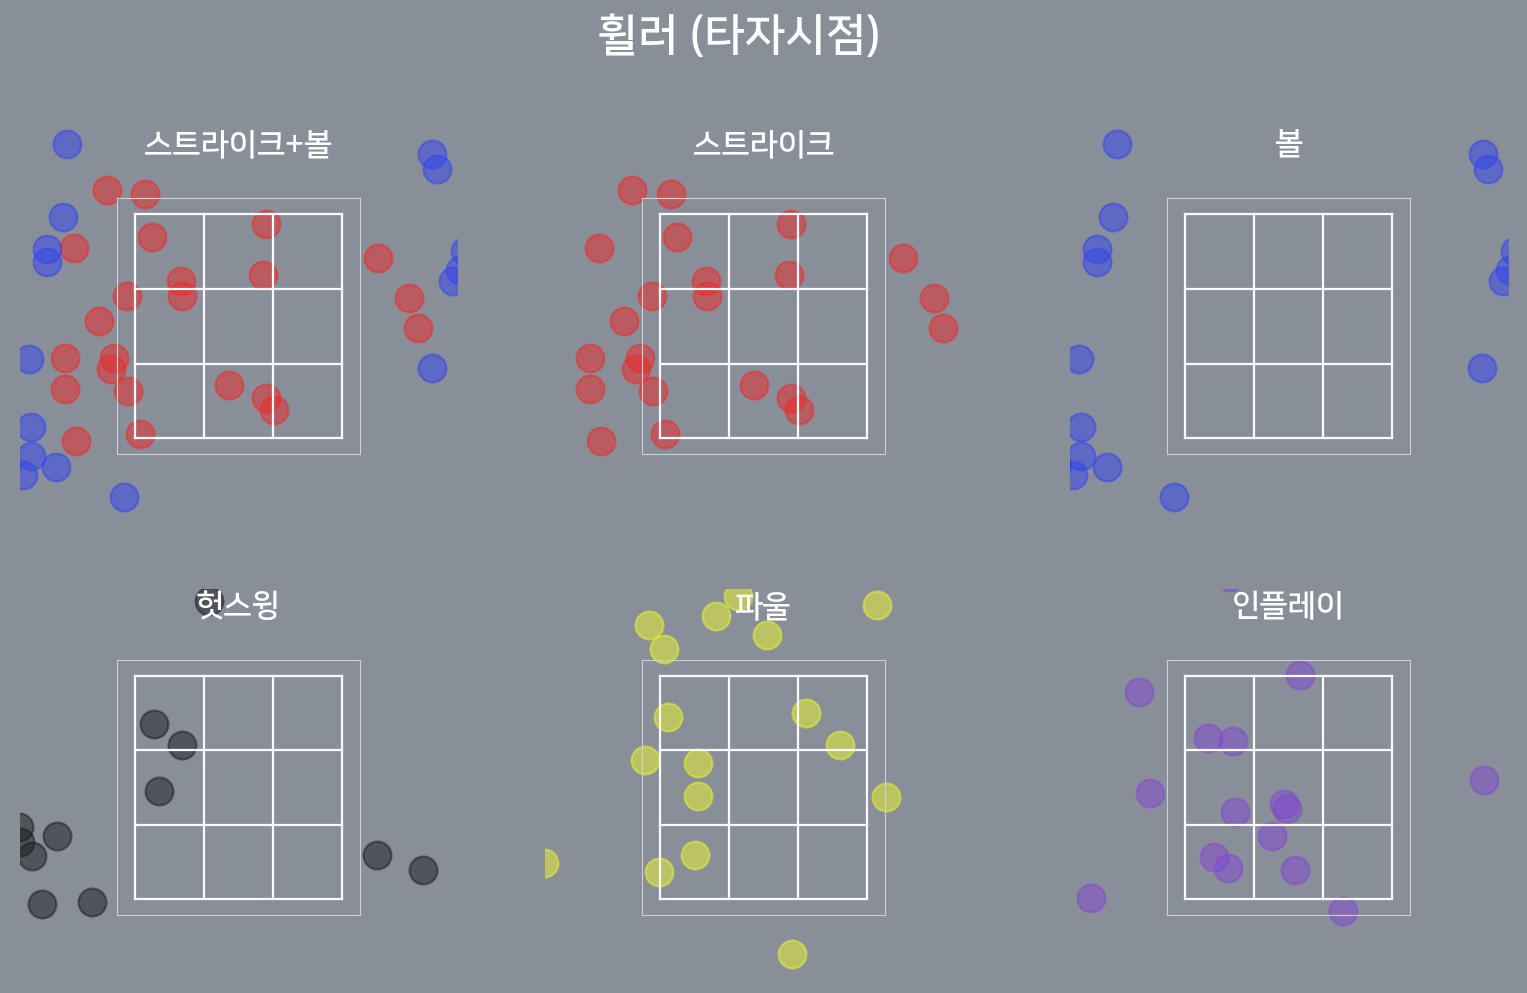

In [68]:
plot_match_calls(sub_df, title='{} (타자시점)'.format(p))

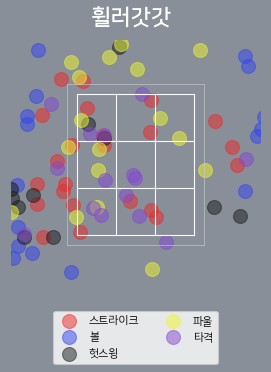

In [71]:
plot_calls(sub_df, title='휠러갓갓', calls=['스트라이크', '볼', '헛스윙', '파울', '타격'], legends=True)

In [67]:
p = '휠러'

!python pbp.py -d 2018 3 > /dev/null
!python pbp.py -c 2018 3 > /dev/null

df = pd.read_csv('pbp_data/2018/2018.csv')


df.loc[:, 'speed'] = pd.to_numeric(df.speed, errors='coerce')
df.loc[:, 'px'] = pd.to_numeric(df.px, errors='coerce')
df.loc[:, 'pz'] = pd.to_numeric(df.pz, errors='coerce')
df.loc[:, 'pfx_x'] = pd.to_numeric(df.pfx_x, errors='coerce')
df.loc[:, 'pfx_z'] = pd.to_numeric(df.pfx_z, errors='coerce')
df.loc[:, 'x0'] = pd.to_numeric(df.x0, errors='coerce')
df.loc[:, 'z0'] = pd.to_numeric(df.z0, errors='coerce')

sub_df = df.loc[df.pitcher == p]

sub_df = sub_df.drop(sub_df.loc[sub_df.px.isnull()].index)
sub_df = sub_df.drop(sub_df.loc[sub_df.pitch_type.isnull()].index)
sub_df = sub_df.drop(sub_df.loc[sub_df.pitch_type == 'None'].index)
dsf = sub_df.groupby('pitch_type').mean().loc[:, ('speed', 'pfx_x', 'pfx_z')]
dsf['count'] = sub_df.groupby('pitch_type').count().speed
dsf['max'] = sub_df.groupby('pitch_type').max().speed
dsf['min'] = sub_df.groupby('pitch_type').min().speed

display(dsf)
#display(sub_df.loc[:, ('pitcher', 'batter', 'pitch_type', 'pitch_result', 'pa_result', 'speed', 'pfx_x', 'pfx_z', 'balls', 'strikes', 'outs', 'inning', 'inning_topbot')])

,speed,pfx_x,pfx_z,count,max,min
pitch_type,,,,,,
슬라이더,133.7,3.2,8.0,35,137.0,129.0
직구,141.4,9.3,13.2,47,145.0,138.0
체인지업,129.9,11.1,13.8,10,133.0,128.0
커브,126.0,0.3,4.5,2,127.0,125.0
투심,138.2,10.9,12.7,10,140.0,137.0


In [15]:
df = pd.read_csv('pbp_data/2017/2017.csv')
#pitchers = df.pitcher.drop_duplicates()
#pitch_types = df.pitch_type.drop_duplicates()

# string으로 된 숫자를 float, int등 numeric으로 바꾼다.
df.loc[:, 'px'] = pd.to_numeric(df.px, errors='coerce')
df.loc[:, 'pz'] = pd.to_numeric(df.pz, errors='coerce')
df.loc[:, 'pfx_x'] = pd.to_numeric(df.pfx_x, errors='coerce')
df.loc[:, 'pfx_z'] = pd.to_numeric(df.pfx_z, errors='coerce')
df.loc[:, 'sz_top'] = pd.to_numeric(df.sz_top, errors='coerce')
df.loc[:, 'sz_bot'] = pd.to_numeric(df.sz_bot, errors='coerce')

In [16]:
# pitch type 분석이 필요한 경우, pitch_type이 NaN 또는 None으로 된 row를 drop한다.
df = df.drop(df.loc[(df.pitch_type.isnull()) | (df.pitch_type == 'None')].index)

In [17]:
# 헛스윙/스윙/파울 분석이 필요한 경우, pitch_result의 번트파울과 번트헛스윙을 파울과 헛스윙으로 바꾼다.
df.pitch_result = df.pitch_result.replace('번트헛스윙', '헛스윙')
df.pitch_result = df.pitch_result.replace('번트파울', '파울')

In [8]:
ll = -17/24  # leftLine
rl = +17/24  # rightLine
oll = -17/24-1/8  # outerLeftLine
orl = +17/24+1/8  # outerRightLine

tl = +3.325  # topLine
bl = +1.579  # bototmLine
otl = +3.325+1/8  # outerTopLine
obl = +1.579-1/8  # outerBottomLine

In [28]:
iz = df.loc[(df.px <= orl) & (df.px >= oll) & (df.pz >= df.sz_bot-1/8) & (df.pz <= df.sz_top+1/8)]
oz = df.loc[(df.px > orl) | (df.px < oll) | (df.pz < df.sz_bot-1/8) & (df.pz > df.sz_top+1/8)]
iz_s = iz.loc[iz.pitch_result == '스트라이크']
iz_b = iz.loc[iz.pitch_result == '볼']
oz_s = oz.loc[oz.pitch_result == '스트라이크']
oz_b = oz.loc[oz.pitch_result == '볼']
iz_acc = len(iz_s) / (len(iz_s) + len(iz_b))
oz_acc = len(oz_b) / (len(oz_s) + len(oz_b))

print(iz_acc, oz_acc)

0.8444314507807663 0.8273502843760455


In [30]:
iz = df.loc[(df.px <= rl) & (df.px >= ll) & (df.pz >= df.sz_bot) & (df.pz <= df.sz_top)]
oz = df.loc[(df.px > rl) | (df.px < ll) | (df.pz < df.sz_bot) & (df.pz > df.sz_top)]
iz_s = iz.loc[iz.pitch_result == '스트라이크']
iz_b = iz.loc[iz.pitch_result == '볼']
oz_s = oz.loc[oz.pitch_result == '스트라이크']
oz_b = oz.loc[oz.pitch_result == '볼']
iz_acc = len(iz_s) / (len(iz_s) + len(iz_b))
oz_acc = len(oz_b) / (len(oz_s) + len(oz_b))

print(iz_acc, oz_acc)

0.9060289502037757 0.7881377156410672


In [29]:
yhk = df.loc[df.pitcher == '유희관']

iz = yhk.loc[(yhk.px <= orl) & (yhk.px >= oll) & (yhk.pz >= yhk.sz_bot-1/8) & (yhk.pz <= yhk.sz_top+1/8)]
oz = yhk.loc[(yhk.px > orl) | (yhk.px < oll) | (yhk.pz < yhk.sz_bot-1/8) & (yhk.pz > yhk.sz_top+1/8)]
iz_s = iz.loc[iz.pitch_result == '스트라이크']
iz_b = iz.loc[iz.pitch_result == '볼']
oz_s = oz.loc[oz.pitch_result == '스트라이크']
oz_b = oz.loc[oz.pitch_result == '볼']
iz_acc = len(iz_s) / (len(iz_s) + len(iz_b))
oz_acc = len(oz_b) / (len(oz_s) + len(oz_b))

print(iz_acc, oz_acc)

0.8934426229508197 0.708498023715415


In [31]:
yhk = df.loc[df.pitcher == '유희관']

iz = yhk.loc[(yhk.px <= rl) & (yhk.px >= ll) & (yhk.pz >= yhk.sz_bot) & (yhk.pz <= yhk.sz_top)]
oz = yhk.loc[(yhk.px > rl) | (yhk.px < ll) | (yhk.pz < yhk.sz_bot) & (yhk.pz > yhk.sz_top)]
iz_s = iz.loc[iz.pitch_result == '스트라이크']
iz_b = iz.loc[iz.pitch_result == '볼']
oz_s = oz.loc[oz.pitch_result == '스트라이크']
oz_b = oz.loc[oz.pitch_result == '볼']
iz_acc = len(iz_s) / (len(iz_s) + len(iz_b))
oz_acc = len(oz_b) / (len(oz_s) + len(oz_b))

print(iz_acc, oz_acc)

0.9294117647058824 0.6773913043478261


In [45]:
yhk = df.loc[df.pitcher == '피어밴드']

iz = yhk.loc[(yhk.px <= orl) & (yhk.px >= oll) & (yhk.pz >= yhk.sz_bot-1/8) & (yhk.pz <= yhk.sz_top+1/8)]
oz = yhk.loc[(yhk.px > orl) | (yhk.px < oll) | (yhk.pz < yhk.sz_bot-1/8) & (yhk.pz > yhk.sz_top+1/8)]
iz_s = iz.loc[iz.pitch_result == '스트라이크']
iz_b = iz.loc[iz.pitch_result == '볼']
oz_s = oz.loc[oz.pitch_result == '스트라이크']
oz_b = oz.loc[oz.pitch_result == '볼']
iz_acc = len(iz_s) / (len(iz_s) + len(iz_b))
oz_acc = len(oz_b) / (len(oz_s) + len(oz_b))

print(iz_acc, oz_acc)

0.8592814371257484 0.8038095238095239


In [45]:
yhk = df.loc[df.pitcher == '피어밴드']

iz = yhk.loc[(yhk.px <= orl) & (yhk.px >= oll) & (yhk.pz >= yhk.sz_bot-1/8) & (yhk.pz <= yhk.sz_top+1/8)]
oz = yhk.loc[(yhk.px > orl) | (yhk.px < oll) | (yhk.pz < yhk.sz_bot-1/8) & (yhk.pz > yhk.sz_top+1/8)]
iz_s = iz.loc[iz.pitch_result == '스트라이크']
iz_b = iz.loc[iz.pitch_result == '볼']
oz_s = oz.loc[oz.pitch_result == '스트라이크']
oz_b = oz.loc[oz.pitch_result == '볼']
iz_acc = len(iz_s) / (len(iz_s) + len(iz_b))
oz_acc = len(oz_b) / (len(oz_s) + len(oz_b))

print(iz_acc, oz_acc)

0.8592814371257484 0.8038095238095239


In [47]:
pitchers = df.pitcher.drop_duplicates()

_1500 = []
for pitcher in pitchers:
    if len(df.loc[df.pitcher == pitcher]) > 1500:
        _1500.append(pitcher)
        
print(_1500)

['니퍼트', '비야누에바', '페트릭', '헥터', '백정현', '임기영', '켈리', '로치', '고영표', '밴헤켄', '소사', '맨쉽', '레일리', '유희관', '오간도', '윤규진', '윤희상', '류제국', '한현희', '이재학', '김원중', '장현식', '윤성환', '문승원', '피어밴드', '신재영', '구창모', '박진형', '송승준', '배영수', '장원준', '정성곤', '양현종', '박종훈', '차우찬', '박세웅', '최원태', '해커', '함덕주', '우규민', '팻딘', '임찬규', '다이아몬드', '보우덴', '허프', '브리검']


In [54]:
_list = []

for p in _1500:
    yhk = df.loc[df.pitcher == p]

    iz = yhk.loc[(yhk.px <= orl) & (yhk.px >= oll) & (yhk.pz >= yhk.sz_bot-1/8) & (yhk.pz <= yhk.sz_top+1/8)]
    oz = yhk.loc[(yhk.px > orl) | (yhk.px < oll) | (yhk.pz < yhk.sz_bot-1/8) & (yhk.pz > yhk.sz_top+1/8)]
    iz_s = iz.loc[iz.pitch_result == '스트라이크']
    iz_b = iz.loc[iz.pitch_result == '볼']
    oz_s = oz.loc[oz.pitch_result == '스트라이크']
    oz_b = oz.loc[oz.pitch_result == '볼']
    iz_acc = len(iz_s) / (len(iz_s) + len(iz_b))
    oz_acc = len(oz_b) / (len(oz_s) + len(oz_b))

    _list.append( (p, iz_acc, oz_acc) )

In [55]:
_list

[('니퍼트', 0.8545918367346939, 0.8283038501560874),
 ('비야누에바', 0.8419117647058824, 0.8008752735229759),
 ('페트릭', 0.8923076923076924, 0.7902813299232737),
 ('헥터', 0.8513513513513513, 0.7925840092699884),
 ('백정현', 0.8793969849246231, 0.805045871559633),
 ('임기영', 0.8693877551020408, 0.829443447037702),
 ('켈리', 0.8498583569405099, 0.827020202020202),
 ('로치', 0.814621409921671, 0.8582554517133957),
 ('고영표', 0.8664383561643836, 0.8154859967051071),
 ('밴헤켄', 0.8284182305630027, 0.8225255972696246),
 ('소사', 0.8137755102040817, 0.8169440242057489),
 ('맨쉽', 0.8893280632411067, 0.7820738137082601),
 ('레일리', 0.8436123348017621, 0.8615384615384616),
 ('유희관', 0.8934426229508197, 0.708498023715415),
 ('오간도', 0.8893617021276595, 0.8346153846153846),
 ('윤규진', 0.8280701754385965, 0.8008213552361396),
 ('윤희상', 0.8643410852713178, 0.8061420345489443),
 ('류제국', 0.830028328611898, 0.8342618384401114),
 ('한현희', 0.8644859813084113, 0.8449905482041588),
 ('이재학', 0.8444444444444444, 0.8346153846153846),
 ('김원중', 

In [39]:
yhk = df.loc[df.pitcher == '니퍼트']

iz = yhk.loc[(yhk.px <= rl) & (yhk.px >= ll) & (yhk.pz >= yhk.sz_bot) & (yhk.pz <= yhk.sz_top)]
oz = yhk.loc[(yhk.px > rl) | (yhk.px < ll) | (yhk.pz < yhk.sz_bot) & (yhk.pz > yhk.sz_top)]
iz_s = iz.loc[iz.pitch_result == '스트라이크']
iz_b = iz.loc[iz.pitch_result == '볼']
oz_s = oz.loc[oz.pitch_result == '스트라이크']
oz_b = oz.loc[oz.pitch_result == '볼']
iz_acc = len(iz_s) / (len(iz_s) + len(iz_b))
oz_acc = len(oz_b) / (len(oz_s) + len(oz_b))

print(iz_acc, oz_acc)

0.9247311827956989 0.7888989990900819


In [281]:
# 스트존 상/중/하 swstr% 구하기; swstr% = 헛스윙/전체 pitch(구종별)
sub_df = pd.DataFrame({'pitch_type': df.pitch_type, 'pitch_result': df.pitch_result, 'px': df.px, 'pz': df.pz, 'swstr%': 1})

ll = -17/24  # leftLine
rl = +17/24  # rightLine
oll = -17/24-1/8  # outerLeftLine
orl = +17/24+1/8  # outerRightLine

tl = +3.325  # topLine
bl = +1.579  # bototmLine
otl = +3.325+1/8  # outerTopLine
obl = +1.579-1/8  # outerBottomLine

top_range = [ (tl*2 + bl*1)/3, otl ]
mid_range = [ (tl*1 + bl*2)/3, (tl*2 + bl*1)/3 ]
bot_range = [ obl, (tl*1 + bl*2)/3 ]

# 존 경계선(공 반개 포함) 안에 있는 공만 남긴다.
sub_df = sub_df.drop( sub_df.loc[(sub_df.px > orl) | (sub_df.px < oll)].index )
sub_df = sub_df.drop( sub_df.loc[(sub_df.pz > otl) | (sub_df.pz < obl)].index )

# 직구만 남긴다.
sub_df = sub_df.drop( sub_df.loc[sub_df.pitch_type != '직구'].index )

ranges = [[top_range, '상단'], [mid_range, '중단'], [bot_range, '하단']]
PRINT_FORMAT = '{0} 헛스윙% : {1:.1f}%'

for r, name in ranges:
    sub_df2 = sub_df.loc[(sub_df.pz <= r[-1]) & (sub_df.pz >= r[0])]
    balls = pd.DataFrame({'pitch_result': sub_df2.pitch_result, 'raw_num': sub_df2['swstr%']})
    result = balls.groupby('pitch_result').sum().apply(lambda x: 100*x/x.sum())
    
    print(PRINT_FORMAT.format(name, result.loc['헛스윙'].raw_num))



상단 헛스윙% : 10.9%
중단 헛스윙% : 7.1%
하단 헛스윙% : 4.4%


In [6]:
# 스트존 상단 +-2인치 투구 비율 구하기
sub_df = pd.DataFrame({'px': df.px, 'pz': df.pz, 'raw_num': 1})

ll = -17/24  # leftLine
rl = +17/24  # rightLine
oll = -17/24-1/8  # outerLeftLine
orl = +17/24+1/8  # outerRightLine

tl = +3.325  # topLine
bl = +1.579  # bototmLine
otl = +3.325+1/8  # outerTopLine
obl = +1.579-1/8  # outerBottomLine

# 존 경계선(공 반개 포함) 안에 있는 공만 남긴다.
sub_df = sub_df.drop( sub_df.loc[(sub_df.px > orl) | (sub_df.px < oll)].index )
sub_df = sub_df.drop( sub_df.loc[(sub_df.pz > otl) | (sub_df.pz < obl)].index )

# 상단 +-2인치 안의 공 비율만 계산.
total = len(sub_df)

interest = len(sub_df.loc[(sub_df.pz <= tl + 2/12) & (sub_df.pz >= tl - 2/12)])

print(total, interest, round(interest/total*100, 1))

92486 8753 9.5


In [8]:
df16 = pd.read_csv('pbp_data/2016/2016.csv')
#pitchers = df.pitcher.drop_duplicates()
#pitch_types = df.pitch_type.drop_duplicates()

# string으로 된 숫자를 float, int등 numeric으로 바꾼다.
df16.loc[:, 'px'] = pd.to_numeric(df16.px, errors='coerce')
df16.loc[:, 'pz'] = pd.to_numeric(df16.pz, errors='coerce')
df16.loc[:, 'pfx_x'] = pd.to_numeric(df16.pfx_x, errors='coerce')
df16.loc[:, 'pfx_z'] = pd.to_numeric(df16.pfx_z, errors='coerce')

# 스트존 상단 +-2인치 투구 비율 구하기
sub_df = pd.DataFrame({'px': df16.px, 'pz': df16.pz, 'raw_num': 1})

ll = -17/24  # leftLine
rl = +17/24  # rightLine
oll = -17/24-1/8  # outerLeftLine
orl = +17/24+1/8  # outerRightLine

tl = +3.325  # topLine
bl = +1.579  # bototmLine
otl = +3.325+1/8  # outerTopLine
obl = +1.579-1/8  # outerBottomLine

# 존 경계선(공 반개 포함) 안에 있는 공만 남긴다.
sub_df = sub_df.drop( sub_df.loc[(sub_df.px > orl) | (sub_df.px < oll)].index )
sub_df = sub_df.drop( sub_df.loc[(sub_df.pz > otl) | (sub_df.pz < obl)].index )

# 상단 +-2인치 안의 공 비율만 계산.
total = len(sub_df)

interest = len(sub_df.loc[(sub_df.pz <= tl + 2/12) & (sub_df.pz >= tl - 2/12)])

print(total, interest, round(interest/total*100, 1))

154677 4950 3.2


In [197]:
# swstr% 구하기; swstr% = 헛스윙/전체 pitch (구종별)
sub_df = pd.DataFrame({'pitcher': df.pitcher, 'pitch_type': df.pitch_type, 'pitch_result': df.pitch_result, 'swstr%': 1})

# 구종 종류
pitch_types = df.pitch_type.drop_duplicates()

# 최소 투구수; 구종별
pitch_threshold = 250

for pitch in pitch_types:
    # 해당 구종만 분류; 투수 그룹으로 묶음
    pitchers = sub_df.loc[sub_df.pitch_type == pitch].groupby(['pitcher'])
    
    # 최소 투구수 넘는 경우만 필터
    filtered = pitchers.filter(lambda x: x['swstr%'].sum() > pitch_threshold)
    
    # 필터 통과한 투수 목록
    l = filtered.pitcher.drop_duplicates()
    
    # 특정 구종은 투수가 없는 경우도 있음 - 이런 경우는 패스
    if len(l) == 0:
        print(pitch + ' pass')
        continue
        
    # 구종 필터 걸고, 투수-투구결과(헛스윙/타격/파울 등)로 그룹
    swstrs = sub_df.loc[ (sub_df.pitcher.isin(list(l))) &
                         (sub_df.pitch_type == pitch) ].groupby(['pitcher', 'pitch_result']).agg({'swstr%': 'sum'})

    # pitch result별 swstr%를 구종 투구수 전체로 나눔; 이렇게하면 swstr%가 퍼센티지로 나옴.
    swstr_pcts = swstrs.groupby(level=0).apply(lambda x: 100*x/x.sum())
    
    # 헛스윙 raw num 컬럼도 하나 표시.
    swstr_pcts['raw_num'] = swstrs['swstr%']
    
    print(pitch)
    result = swstr_pcts.iloc[swstr_pcts.index.get_level_values('pitch_result') == '헛스윙'].sort_values('swstr%', ascending=False)

    display(result[:3])

직구


,,swstr%,raw_num
pitcher,pitch_result,,
정우람,헛스윙,15.3,97
신재웅,헛스윙,12.5,42
임창용,헛스윙,12.3,58


슬라이더


,,swstr%,raw_num
pitcher,pitch_result,,
심창민,헛스윙,22.9,59
장시환,헛스윙,22.7,58
윤길현,헛스윙,19.8,52


커브


,,swstr%,raw_num
pitcher,pitch_result,,
해커,헛스윙,20.0,51
배장호,헛스윙,15.0,69
헥터,헛스윙,13.5,49


체인지업


,,swstr%,raw_num
pitcher,pitch_result,,
고영표,헛스윙,25.1,172
함덕주,헛스윙,21.1,123
켈리,헛스윙,20.2,125


투심


,,swstr%,raw_num
pitcher,pitch_result,,
박희수,헛스윙,12.1,31
켈리,헛스윙,11.4,38
원종현,헛스윙,10.8,28


포크


,,swstr%,raw_num
pitcher,pitch_result,,
김진성,헛스윙,26.4,155
이민호,헛스윙,23.0,80
최충연,헛스윙,22.3,65


싱커 pass
커터


,,swstr%,raw_num
pitcher,pitch_result,,
손승락,헛스윙,14.3,67
켈리,헛스윙,14.1,74
허프,헛스윙,9.3,53


너클볼


,,swstr%,raw_num
pitcher,pitch_result,,
피어밴드,헛스윙,11.6,49
